# Overview
The task is to identify sleep patterns given samples of accelerometer data. 

In [1]:
# Render our plots inline
%matplotlib inline

import numpy as np
import h5py
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame
import itertools
from sklearn.cross_validation import train_test_split, cross_val_score
import math


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_data(filename):
    path = 'D:/path/'+ filename
    hf = h5py.File(path, 'r')

    reread = pd.read_hdf(path)
    data = reread#.head(10000)
    hf.close()
    return data

def load_targets(subject_number):
    filepath = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_targets.h5'
    hf = h5py.File(filepath, 'r')

    reread = pd.read_hdf(filepath)
    targets = reread#.head(10000)
    hf.close()
    return targets

def load_features(subject_number):
    filepath = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_features.h5'
    hf = h5py.File(filepath, 'r')

    reread = pd.read_hdf(filepath)
    features = reread#.head(10000)
    hf.close()
    return features

In [3]:
def combine_data(subject_ids):
    
    data = []
    y = []
    
    
    for i in range(len(subject_ids)):
        
        features = load_features(subject_ids[i])
        targets = load_targets(subject_ids[i])
        
        data.append(features)
        y.append(targets)
    
    result_X = pd.concat(data)
    result_X = result_X.reset_index()
    result_X = result_X.drop(['index'], axis = 1)
    
    result_y = pd.concat(y)
    result_y = result_y.reset_index()
    result_y = result_y.drop(['index'], axis = 1)
    
    return result_X.values, result_y.values.ravel()
    

In [4]:
#Get training and test data
#subject_ids = [1,6,14,15,18,19,20,23,24,25,27,28,29,30,31,32,35,37,39]

train_ids =[1, 6, 15, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 37, 39]

test_ids = [14, 18]

X_train, y_train = combine_data(train_ids)
X_test, y_test = combine_data(test_ids)


In [5]:
test_index = len(y_train)

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

# Feature selection

In [6]:
#Removing features with low variance
# We want to remove all features that are either one or zero (on or off) in more than 80% of the samples
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.80 * (1 - .80)))
X_vt = sel.fit_transform(X)

print('Number of features removed:' + str(X.shape[1]-X_vt.shape[1]))
print('Number of features left:' + str(X_vt.shape[1]))

Number of features removed:35
Number of features left:65


In [7]:
# Univariate feature selection - KBest
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X_uni_c = SelectKBest(f_classif, k=20).fit_transform(X, y)

print('Number of features removed:' + str(X.shape[1]-X_uni_c.shape[1]))
print('Number of features left:' + str(X_uni_c.shape[1]))

Number of features removed:80
Number of features left:20


In [8]:
# L1-based feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_l1 = model.transform(X)

print('Number of features removed:' + str(X.shape[1]-X_l1.shape[1]))
print('Number of features left:' + str(X_l1.shape[1]))

Number of features removed:42
Number of features left:58


In [9]:
# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
#clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_tree = model.transform(X)

print('Number of features removed:' + str(X.shape[1]-X_tree.shape[1]))
print('Number of features left:' + str(X_tree.shape[1]))

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Number of features removed:71
Number of features left:29


# Model building and evaluation

In [10]:
#from sklearn.cross_validation import train_test_split, cross_val_score

x = X

#Train/test split
X_train= x[0:test_index].copy()
X_test = x[test_index:].copy()

y_train = y[0:test_index].copy()
y_test = y[test_index:].copy()


In [11]:
import sklearn.metrics as met
import seaborn as sn
    
# helper function to quickly build different models
def model_build(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(array):
    array = array
    x_labels = ['sleep', 'wake']
    y_labels = ['sleep', 'wake']
    df_cm = pd.DataFrame(array, y_labels,x_labels)
    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')# font size
    plt.show()

# helper function to handle evaluation
def model_eval(model, X_test, y_test):
    pred = model.predict(X_test)
    print('Accuracy:\n-----------------------------')
    print(met.accuracy_score(y_test, pred))
    print('\nConfusion Matrix:\n-----------------------------')
    conf = met.confusion_matrix(y_test, pred)
    plot_confusion_matrix(conf)
    #print(met.confusion_matrix(y_test, pred))
    print('\nClassification Report:\n-----------------------------')
    print(met.classification_report(y_test, pred, digits= 5))

    TP = conf.tolist()[0][0]
    FN = conf.tolist()[0][1]
    FP = conf.tolist()[1][0]
    TN = conf.tolist()[1][1]
    sen = TP/(TP+FN)
    spe = TN/(TN+FP)
    gmean= math.sqrt(sen*spe)
    
    print('TP, FN, FP, TN: '+ str(TN)+', '+ str(FP)+', '+str(FN)+', '+str(TP))
    print('Sensitivity:' + str(sen))
    print('Specificity:' + str(spe))
    print('G-mean:'+ str(gmean))


# Training and validation

Accuracy:
-----------------------------
0.7913549459684123

Confusion Matrix:
-----------------------------


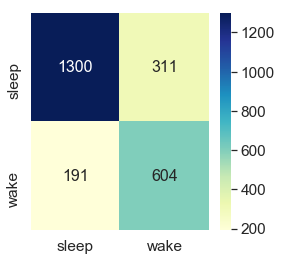


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.87190   0.80695   0.83817      1611
          2    0.66011   0.75975   0.70643       795

avg / total    0.80192   0.79135   0.79464      2406

TP, FN, FP, TN: 604, 191, 311, 1300
Sensitivity:0.8069522036002483
Specificity:0.759748427672956
G-mean:0.7829946793513451


In [12]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

dtc = model_build(DecisionTreeClassifier(), X_train, y_train)
model_eval(dtc, X_test,y_test)

Accuracy:
-----------------------------
0.9019118869492935

Confusion Matrix:
-----------------------------


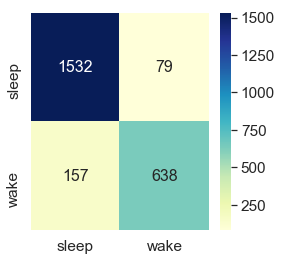


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90705   0.95096   0.92848      1611
          2    0.88982   0.80252   0.84392       795

avg / total    0.90135   0.90191   0.90054      2406

TP, FN, FP, TN: 638, 157, 79, 1532
Sensitivity:0.9509621353196772
Specificity:0.8025157232704403
G-mean:0.8735914753641275


In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = model_build(RandomForestClassifier(n_estimators=20), X_train, y_train)
model_eval(rfc, X_test, y_test)


Accuracy:
-----------------------------
0.9156275976724855

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


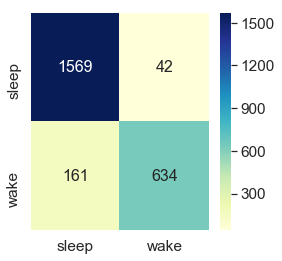


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90694   0.97393   0.93924      1611
          2    0.93787   0.79748   0.86200       795

avg / total    0.91716   0.91563   0.91372      2406

TP, FN, FP, TN: 634, 161, 42, 1569
Sensitivity:0.9739292364990689
Specificity:0.7974842767295598
G-mean:0.8813020213044064


In [14]:
# Extreme Gradient Boosting
from xgboost import XGBClassifier

xgbc = model_build(XGBClassifier(n_estimators=150), X_train, y_train)
model_eval(xgbc, X_test, y_test)


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


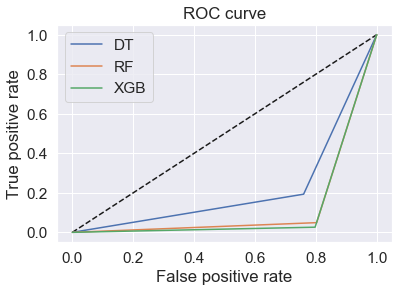

In [15]:
#ROC -curve

pred_dt = dtc.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = met.roc_curve(y_test, pred_dt, pos_label=1)

pred_rf = rfc.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = met.roc_curve(y_test, pred_rf, pos_label=1)

pred_xgb = xgbc.predict(X_test)
fpr_xgb, tpr_xgb, thresholds_dt = met.roc_curve(y_test, pred_xgb, pos_label=1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()